In [ ]:
# --- System/Package Setup (Google Colab) ---
# If you're on Colab, run this cell once. It installs all required libs and prints versions.

!pip -q install --upgrade pip
!pip -q install yfinance riskfolio-lib==4.1.0
!pip -q install "stable-baselines3==2.3.2" "gymnasium==0.29.1" "shimmy==1.3.0"
!pip -q install pandas numpy scipy "matplotlib>=3.8" numba

# (Optional) Uncomment if you want progress bars for training/eval
# !pip -q install tqdm

# --- Imports & Version Check ---
import sys, platform, importlib, warnings
import numpy as np, pandas as pd, matplotlib as mpl
import gymnasium as gym
import yfinance as yf
import riskfolio as rp
import stable_baselines3 as sb3

import torch

warnings.filterwarnings("ignore")

print("Python        :", sys.version.split()[0])
print("Platform      :", platform.platform())
print("NumPy         :", np.__version__)
print("Pandas        :", pd.__version__)
print("Matplotlib    :", mpl.__version__)
print("Gymnasium     :", gym.__version__)
print("SB3           :", sb3.__version__)
print("PyTorch       :", torch.__version__)
print("yfinance      :", yf.__version__)
print("riskfolio-lib :", importlib.metadata.version('riskfolio-lib'))

# Quick sanity: check CUDA availability (Colab GPU runtime recommended but not required)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("CUDA device   :", torch.cuda.get_device_name(0))

# Repro seeds (we'll also seed inside the RL training later)
import random
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

print("\n✅ Setup complete. Ready for configs.")


Python        : 3.12.11
Platform      : Linux-6.1.123+-x86_64-with-glibc2.35
NumPy         : 2.0.2
Pandas        : 2.2.2
Matplotlib    : 3.10.0
Gymnasium     : 0.29.1
SB3           : 2.3.2
PyTorch       : 2.8.0+cu126
yfinance      : 0.2.65
riskfolio-lib : 4.1.0
CUDA available: False

✅ Setup complete. Ready for configs.


In [ ]:
# --- Configuration (Colab-ready) ---

from pathlib import Path
from datetime import datetime
import numpy as np
import pprint, json, os, random

# Reproducibility
GLOBAL_SEED = 42
random.seed(GLOBAL_SEED)
np.random.seed(GLOBAL_SEED)

# Paths
BASE_DIR = Path("/content")
DATA_DIR = BASE_DIR / "data"
CACHE_DIR = BASE_DIR / "experts_cache"
MODELS_DIR = BASE_DIR / "models"
OUTPUTS_DIR = BASE_DIR / "outputs"
for d in [DATA_DIR, CACHE_DIR, MODELS_DIR, OUTPUTS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

# ---------- Universe & cadence ----------
CFG_UNIVERSE = {
    "assets": ["SPY", "IEFA", "EEM", "IEI", "IEF", "TLT", "LQD", "HYG", "GLD", "DBC"],
    "start_date": "2005-01-01",
    "end_date":   "2025-09-01",
    # Weekly decisions every Friday; we'll map to the next week’s returns
    "decision_freq": "W-FRI",
    "total_return": True  # use dividend-adjusted close
}

# ---------- Frictions & constraints ----------
CFG_COSTS = {
    "commission_bps": 2.0,     # per side
    "slippage_bps":   0.0,     # folded into commission for simplicity
}
CFG_CONSTRAINTS = {
    "turnover_cap": 0.20,      # max fraction of NAV traded per decision
    "max_weight":   0.35,      # per-asset cap
    "allow_cash":   True,
    "max_cash":     0.05
}

# ---------- Expert pool (HRP/HERC variants) ----------
CFG_EXPERTS = {
    "lookbacks_days": [60, 120, 252, 504, 756, 1008],  # rolling windows
    "hrp": {
        "linkage": "single",        # classic HRP recipe
        "risk": "variance"          # variance for HRP
    },
    "herc": {
        "linkage": "ward",          # HERC tends to prefer Ward
        "risk": "cdar",             # downside risk metric
        "alpha": 0.05,              # CDaR@5%
        "gap_statistic": True,
        "max_clusters": 10
    }
}
N_EXPERTS = 12  # 6 HRP + 6 HERC (one per lookback)
ACTION_HOLD = N_EXPERTS  # index for HOLD action in the RL env

# ---------- PPO / RL knobs ----------
CFG_PPO = {
    "algo": "PPO",
    "net_hidden": [1024, 512],
    "gamma": 0.99,
    "gae_lambda": 0.95,
    "entropy_coef": 0.005,
    "clip_range": 0.30,
    "kl_coef": 0.20,
    "learning_rates": [1e-4, 1e-3],
    "batch_size": 256,
    "steps_per_epoch": 2048,
    "total_timesteps": 400_000,   # initial budget; can increase later
    "seed": GLOBAL_SEED,
    "reward": {
        "trade_cost_bps": 2.0,    # applied to turnover per decision
        "kappa_turnover": 0.002,  # turnover regularizer
        "hold_bonus": 0.0005      # small bonus when stress & HOLD
    },
    "state": {
        "perf_windows_weeks": [1, 4, 12],
        "use_realized_vol_ewma20": True,
        "use_trend_spy_tlt": True,
        "stress_thresholds": {
            "spy_weekly_ret": -0.01,
            "ief_weekly_ret":  0.003
        }
    },
    "constraints": CFG_CONSTRAINTS
}

# ---------- Train/Val/Test splits ----------
CFG_SPLITS = {
    "train_start": "2010-01-01",
    "train_end":   "2018-12-31",
    "val_start":   "2019-01-01",
    "val_end":     "2019-12-31",
    "oos_start":   "2020-01-01",
    "oos_end":     CFG_UNIVERSE["end_date"],
    "rolling_yearly": True,   # we can roll the windows yearly later
    "reversed_chronology": True
}

# ---------- Pretty print a short summary ----------
def show_config():
    print("=== Universe ===")
    print(CFG_UNIVERSE)
    print("\n=== Costs & Constraints ===")
    print({**CFG_COSTS, **CFG_CONSTRAINTS})
    print("\n=== Experts ===")
    print(CFG_EXPERTS)
    print("\n=== PPO ===")
    tmp = CFG_PPO.copy()
    tmp["reward"] = CFG_PPO["reward"].copy()
    tmp["state"] = CFG_PPO["state"].copy()
    print(tmp)
    print("\n=== Splits ===")
    print(CFG_SPLITS)
    print("\nPaths:", {"DATA": str(DATA_DIR),
                      "CACHE": str(CACHE_DIR),
                      "MODELS": str(MODELS_DIR),
                      "OUTPUTS": str(OUTPUTS_DIR)})
    print(f"\nN_EXPERTS={N_EXPERTS}, ACTION_HOLD={ACTION_HOLD}")

show_config()
print("\n✅ Configs loaded.")


=== Universe ===
{'assets': ['SPY', 'IEFA', 'EEM', 'IEI', 'IEF', 'TLT', 'LQD', 'HYG', 'GLD', 'DBC'], 'start_date': '2005-01-01', 'end_date': '2025-09-01', 'decision_freq': 'W-FRI', 'total_return': True}

=== Costs & Constraints ===
{'commission_bps': 2.0, 'slippage_bps': 0.0, 'turnover_cap': 0.2, 'max_weight': 0.35, 'allow_cash': True, 'max_cash': 0.05}

=== Experts ===
{'lookbacks_days': [60, 120, 252, 504, 756, 1008], 'hrp': {'linkage': 'single', 'risk': 'variance'}, 'herc': {'linkage': 'ward', 'risk': 'cdar', 'alpha': 0.05, 'gap_statistic': True, 'max_clusters': 10}}

=== PPO ===
{'algo': 'PPO', 'net_hidden': [1024, 512], 'gamma': 0.99, 'gae_lambda': 0.95, 'entropy_coef': 0.005, 'clip_range': 0.3, 'kl_coef': 0.2, 'learning_rates': [0.0001, 0.001], 'batch_size': 256, 'steps_per_epoch': 2048, 'total_timesteps': 400000, 'seed': 42, 'reward': {'trade_cost_bps': 2.0, 'kappa_turnover': 0.002, 'hold_bonus': 0.0005}, 'state': {'perf_windows_weeks': [1, 4, 12], 'use_realized_vol_ewma20': Tru

In [ ]:
# --- Data Loader: ETFs daily -> weekly decisions & returns ---

import pandas as pd
import numpy as np
import yfinance as yf
from pathlib import Path

# Config shortcuts
tickers = CFG_UNIVERSE["assets"]
start = CFG_UNIVERSE["start_date"]
end = CFG_UNIVERSE["end_date"]
decision_freq = CFG_UNIVERSE["decision_freq"]

DATA_DIR.mkdir(parents=True, exist_ok=True)

def download_adjusted_close(tickers, start, end):
    """Download dividend-adjusted close (total-return proxy) for tickers."""
    df = yf.download(tickers, start=start, end=end, auto_adjust=True, progress=False)["Close"]
    if isinstance(df, pd.Series):
        df = df.to_frame()
    df = df.tz_localize(None) if hasattr(df.index, "tz") else df
    df = df.sort_index()
    # Forward-fill occasional missing days within a week to keep weekly resample clean
    df = df.ffill()
    return df

def to_simple_returns(prices: pd.DataFrame) -> pd.DataFrame:
    rets = prices.pct_change().dropna(how="all")
    return rets

def weekly_prices_from_daily(prices: pd.DataFrame, freq="W-FRI") -> pd.DataFrame:
    """
    Resample daily prices to weekly (Friday close). If Friday is a holiday,
    this takes the last available trading day of that ISO week.
    """
    w = prices.resample(freq).last().dropna(how="all")
    return w

# 1) Download adjusted close (total-return proxy)
prices_d = download_adjusted_close(tickers, start, end)

# Align tickers with full history intersection (drop rows with any NaNs at the start)
# Find first date where all tickers have non-NaN
first_valid_idx = max(prices_d[c].first_valid_index() for c in prices_d.columns)
prices_d = prices_d.loc[first_valid_idx:].copy()
prices_d = prices_d.dropna(how="any")  # ensure a clean panel

# 2) Daily simple returns
returns_d = to_simple_returns(prices_d)

# 3) Weekly decision dates & weekly prices
prices_w = weekly_prices_from_daily(prices_d, decision_freq)
returns_w = prices_w.pct_change().dropna(how="all")  # weekly close-to-close simple returns

# 4) Decision indices (use rows where we have a "next week")
decision_idx = returns_w.index[:-1]         # dates t
next_idx = returns_w.index[1:]              # dates t+1 (for realized PnL)
assert len(decision_idx) == len(next_idx)

# 5) Save to disk (parquet for speed)
prices_d.to_parquet(DATA_DIR / "prices_daily.parquet")
returns_d.to_parquet(DATA_DIR / "returns_daily.parquet")
prices_w.to_parquet(DATA_DIR / "prices_weekly.parquet")
returns_w.to_parquet(DATA_DIR / "returns_weekly.parquet")
pd.Series(decision_idx).to_frame("decision_dates").to_parquet(DATA_DIR / "decision_dates.parquet")
pd.Series(next_idx).to_frame("next_dates").to_parquet(DATA_DIR / "next_dates.parquet")

# 6) Quick summary
print("=== Data Summary ===")
print(f"Tickers: {tickers}")
print(f"Daily span : {prices_d.index.min().date()} → {prices_d.index.max().date()}  (n={len(prices_d):,} days)")
print(f"Weekly span: {prices_w.index.min().date()} → {prices_w.index.max().date()}  (n={len(prices_w):,} Fridays)")
print(f"Decision points: {len(decision_idx):,} (weekly), with next-week mapping available")

display(prices_d.tail(3))
display(returns_d.tail(3))
display(prices_w.tail(3))
display(returns_w.tail(3))

print("\n✅ Data cached to:", DATA_DIR)


=== Data Summary ===
Tickers: ['SPY', 'IEFA', 'EEM', 'IEI', 'IEF', 'TLT', 'LQD', 'HYG', 'GLD', 'DBC']
Daily span : 2012-10-24 → 2025-08-29  (n=3,230 days)
Weekly span: 2012-10-26 → 2025-08-29  (n=671 Fridays)
Decision points: 669 (weekly), with next-week mapping available


Ticker,DBC,EEM,GLD,HYG,IEF,IEFA,IEI,LQD,SPY,TLT
Date,,,,,,,,,,
2025-08-27,22.040001,49.910000,312.709991,80.586479,95.696457,85.720001,119.192436,109.645195,646.630005,86.321815
2025-08-28,22.180000,50.099998,315.029999,80.626289,95.915741,86.040001,119.262230,109.814598,648.919983,86.889656
2025-08-29,22.209999,49.860001,318.070007,80.476997,95.835999,85.510002,119.342003,109.416008,645.049988,86.272003


Ticker,DBC,EEM,GLD,HYG,IEF,IEFA,IEI,LQD,SPY,TLT
Date,,,,,,,,,,
2025-08-27,0.000908,-0.005975,0.002019,0.001237,0.001878,-0.002328,0.001508,0.000364,0.002279,-0.001153
2025-08-28,0.006352,0.003807,0.007419,0.000494,0.002291,0.003733,0.000586,0.001545,0.003541,0.006578
2025-08-29,0.001353,-0.004790,0.009650,-0.001852,-0.000831,-0.006160,0.000669,-0.003630,-0.005964,-0.007108


Ticker,DBC,EEM,GLD,HYG,IEF,IEFA,IEI,LQD,SPY,TLT
Date,,,,,,,,,,
2025-08-15,21.770000,49.939999,307.429993,80.078896,94.919006,86.129997,118.414703,109.356209,643.440002,86.072762
2025-08-22,22.080000,50.630001,310.579987,80.467041,95.457237,87.110001,118.893303,109.814598,645.309998,86.720299
2025-08-29,22.209999,49.860001,318.070007,80.476997,95.835999,85.510002,119.342003,109.416008,645.049988,86.272003


Ticker,DBC,EEM,GLD,HYG,IEF,IEFA,IEI,LQD,SPY,TLT
Date,,,,,,,,,,
2025-08-15,-0.003205,0.010113,-0.017952,0.002992,-0.001573,0.018446,0.000253,0.003016,0.009825,-0.010196
2025-08-22,0.014240,0.013817,0.010246,0.004847,0.005670,0.011378,0.004042,0.004192,0.002906,0.007523
2025-08-29,0.005888,-0.015208,0.024116,0.000124,0.003968,-0.018368,0.003774,-0.003630,-0.000403,-0.005169



✅ Data cached to: /content/data


In [ ]:
# --- HRP/HERC helpers & expert specs ---

import pandas as pd
import numpy as np
from typing import Dict, Any, List
import riskfolio as rp

# Load cached data from Cell 3
prices_d = pd.read_parquet(DATA_DIR / "prices_daily.parquet")
returns_d = pd.read_parquet(DATA_DIR / "returns_daily.parquet")
prices_w = pd.read_parquet(DATA_DIR / "prices_weekly.parquet")
returns_w = pd.read_parquet(DATA_DIR / "returns_weekly.parquet")
decision_dates = pd.read_parquet(DATA_DIR / "decision_dates.parquet")["decision_dates"].dt.tz_localize(None)
next_dates = pd.read_parquet(DATA_DIR / "next_dates.parquet")["next_dates"].dt.tz_localize(None)

ASSETS = CFG_UNIVERSE["assets"]
MAX_W = CFG_CONSTRAINTS["max_weight"]
ALLOW_CASH = CFG_CONSTRAINTS["allow_cash"]
MAX_CASH = CFG_CONSTRAINTS["max_cash"]

# ------------------ utility: clip & normalize weights ------------------

def clip_and_normalize(w: pd.Series,
                       max_weight: float = MAX_W,
                       allow_cash: bool = ALLOW_CASH,
                       max_cash: float = MAX_CASH) -> pd.Series:
    """
    Ensure non-negative, apply per-asset cap, and normalize to sum=1.
    If allow_cash is True, we cap total risky exposure at 1 - max_cash when needed.
    """
    w = w.reindex(ASSETS).fillna(0.0).astype(float)
    w = w.clip(lower=0.0, upper=max_weight)
    risky_sum = w.sum()

    if risky_sum == 0:
        # fallback to equal weights (or all cash if allowed)
        if allow_cash and max_cash > 0:
            # all cash
            w[:] = 0.0
            return w
        else:
            w[:] = 1.0 / len(w)
            return w

    # If cash allowed, ensure risky weights <= 1 - max_cash, leave up to max_cash for cash
    if allow_cash and max_cash > 0:
        cap = 1.0 - max_cash
        if risky_sum > cap:
            w *= (cap / risky_sum)
        # final portfolio will be w (risky) + cash = 1 - sum(w)
        return w

    # Otherwise normalize to 1
    w /= risky_sum
    return w

# ------------------ daily window selector ------------------

def get_daily_window(end_date: pd.Timestamp, lookback_days: int) -> pd.DataFrame:
    """
    Slice the last `lookback_days` of DAILY returns up to and including `end_date`.
    `end_date` should be a weekly decision date; we map to the last daily date <= end_date.
    """
    # Find last daily trading day on/before end_date
    if end_date not in returns_d.index:
        # pick the last index <= end_date
        idx = returns_d.index[returns_d.index <= end_date]
        if len(idx) == 0:
            raise ValueError("No daily data available up to the given end_date.")
        end_daily = idx[-1]
    else:
        end_daily = end_date

    window = returns_d.loc[:end_daily].tail(lookback_days)
    # drop columns with all-NaN within the window (shouldn't happen after alignment)
    window = window.dropna(how="all", axis=1)
    # fill small gaps forward (rare on ETFs)
    window = window.fillna(0.0)
    return window

# ------------------ Riskfolio-Lib wrappers ------------------

def _hc_optimize(returns_window: pd.DataFrame,
                 model: str,
                 rm: str,
                 linkage: str,
                 codependence: str = "pearson",
                 rf: float = 0.0,
                 max_k: int = 10,
                 leaf_order: bool = True,
                 alpha: float = 0.05) -> pd.Series:
    """
    Generic optimizer wrapper for HRP/HERC via riskfolio.HCPortfolio.
    rm: 'MV' (variance), 'CVaR', 'CDaR', etc. (Riskfolio capitalization)
    model: 'HRP' or 'HERC'
    """
    # Defensive: ensure columns match ASSETS and order is stable
    X = returns_window.reindex(columns=ASSETS).copy()
    port = rp.HCPortfolio(returns=X)

    # Map our friendly names to riskfolio
    rm_map = {
        "variance": "MV",
        "mv": "MV",
        "cvar": "CVaR",
        "cdar": "CDaR",
        "CDaR": "CDaR",
        "CVaR": "CVaR",
        "MV": "MV"
    }
    rm_rp = rm_map.get(rm, rm)

    w = port.optimization(
        model=model,
        codependence=codependence,
        rm=rm_rp,
        rf=rf,
        linkage=linkage,
        max_k=max_k,
        leaf_order=leaf_order,
        alpha=alpha  # used by CDaR/CVaR risk measures
    )

    # Riskfolio returns a DataFrame (weights in index). Convert to Series ordered by ASSETS.
    if isinstance(w, pd.DataFrame):
        if "weights" in w.columns:
            w = w["weights"]
        else:
            # sometimes returned as one-column DF without named col
            w = w.iloc[:, 0]
    w = w.reindex(ASSETS).fillna(0.0)
    # ensure non-negative (hierarchical models are long-only by construction)
    w = w.clip(lower=0.0)
    return w

def hrp_weights(returns_window: pd.DataFrame,
                linkage: str = CFG_EXPERTS["hrp"]["linkage"],
                risk: str = CFG_EXPERTS["hrp"]["risk"]) -> pd.Series:
    """
    Compute HRP weights on a daily return window.
    """
    try:
        w = _hc_optimize(returns_window, model="HRP", rm=risk, linkage=linkage)
    except Exception as e:
        # Fallback: inverse-variance weights
        V = returns_window.var()
        inv = 1.0 / V.replace(0, np.nan)
        w = (inv / inv.sum()).fillna(0.0)
    w = clip_and_normalize(w)
    return w

def herc_weights(returns_window: pd.DataFrame,
                 linkage: str = CFG_EXPERTS["herc"]["linkage"],
                 risk: str = CFG_EXPERTS["herc"]["risk"],
                 alpha: float = CFG_EXPERTS["herc"]["alpha"],
                 max_clusters: int = CFG_EXPERTS["herc"]["max_clusters"]) -> pd.Series:
    """
    Compute HERC weights on a daily return window.
    """
    try:
        w = _hc_optimize(returns_window, model="HERC", rm=risk,
                         linkage=linkage, max_k=max_clusters, alpha=alpha)
    except Exception as e:
        # Fallback: equal risk via inverse-variance
        V = returns_window.var()
        inv = 1.0 / V.replace(0, np.nan)
        w = (inv / inv.sum()).fillna(0.0)
    w = clip_and_normalize(w)
    return w

# ------------------ Expert specification (12 experts) ------------------

EXPERT_SPECS: List[Dict[str, Any]] = []
lbs = CFG_EXPERTS["lookbacks_days"]

# 6 HRP (variance) + 6 HERC (CDaR@5%)
for L in lbs:
    EXPERT_SPECS.append({
        "id": f"HRP_L{L}",
        "model": "HRP",
        "lookback": L,
        "params": {
            "linkage": CFG_EXPERTS["hrp"]["linkage"],
            "risk": CFG_EXPERTS["hrp"]["risk"]
        }
    })
for L in lbs:
    EXPERT_SPECS.append({
        "id": f"HERC_CDaR5_L{L}",
        "model": "HERC",
        "lookback": L,
        "params": {
            "linkage": CFG_EXPERTS["herc"]["linkage"],
            "risk": CFG_EXPERTS["herc"]["risk"],  # 'cdar'
            "alpha": CFG_EXPERTS["herc"]["alpha"],
            "max_clusters": CFG_EXPERTS["herc"]["max_clusters"]
        }
    })

assert len(EXPERT_SPECS) == N_EXPERTS, f"Expected {N_EXPERTS} experts, got {len(EXPERT_SPECS)}"

# Preview experts
pd.DataFrame(EXPERT_SPECS)


,id,model,lookback,params
0,HRP_L60,HRP,60,"{'linkage': 'single', 'risk': 'variance'}"
1,HRP_L120,HRP,120,"{'linkage': 'single', 'risk': 'variance'}"
2,HRP_L252,HRP,252,"{'linkage': 'single', 'risk': 'variance'}"
3,HRP_L504,HRP,504,"{'linkage': 'single', 'risk': 'variance'}"
4,HRP_L756,HRP,756,"{'linkage': 'single', 'risk': 'variance'}"
5,HRP_L1008,HRP,1008,"{'linkage': 'single', 'risk': 'variance'}"
6,HERC_CDaR5_L60,HERC,60,"{'linkage': 'ward', 'risk': 'cdar', 'alpha': 0..."
7,HERC_CDaR5_L120,HERC,120,"{'linkage': 'ward', 'risk': 'cdar', 'alpha': 0..."
8,HERC_CDaR5_L252,HERC,252,"{'linkage': 'ward', 'risk': 'cdar', 'alpha': 0..."
9,HERC_CDaR5_L504,HERC,504,"{'linkage': 'ward', 'risk': 'cdar', 'alpha': 0..."


In [ ]:
# --- Expert Cache Builder: compute weights at each decision date and realized next-week perf ---

import pandas as pd
import numpy as np
from pathlib import Path
from time import time

# Reload resources from previous cells
returns_w = pd.read_parquet(DATA_DIR / "returns_weekly.parquet")
decision_dates = pd.read_parquet(DATA_DIR / "decision_dates.parquet")["decision_dates"].dt.tz_localize(None)
next_dates = pd.read_parquet(DATA_DIR / "next_dates.parquet")["next_dates"].dt.tz_localize(None)

# Ensure columns order is stable and matches ASSETS
returns_w = returns_w.reindex(columns=ASSETS)

def compute_expert_cache(expert_spec, verbose_every=25):
    """
    For one expert spec (HRP/HERC + lookback), compute:
      - weights_df: weights at each decision date t (applied on t->t+1)
      - perf_series: realized perf at next_dates (w_t dot returns_w[t+1])
    Saves both to parquet, returns small summary dict.
    """
    eid = expert_spec["id"]
    model = expert_spec["model"]
    L = int(expert_spec["lookback"])
    params = expert_spec["params"]

    print(f"\n▶ Building expert: {eid}  (model={model}, lookback={L} days, params={params})")
    t0 = time()

    # Initialize holder for weights (index = decision dates, columns = assets)
    weights_df = pd.DataFrame(index=decision_dates, columns=ASSETS, dtype=float)

    # Loop over decision dates and compute weights using the last L daily returns up to 't'
    for i, t in enumerate(decision_dates):
        window = get_daily_window(t, lookback_days=L)

        if model == "HRP":
            w = hrp_weights(window, **{k: params[k] for k in ["linkage", "risk"]})
        elif model == "HERC":
            w = herc_weights(window, **params)
        else:
            raise ValueError("Unknown model type")

        weights_df.loc[t, :] = w.reindex(ASSETS).values

        if (i + 1) % verbose_every == 0 or (i + 1) == len(decision_dates):
            print(f"  - {i+1:>4}/{len(decision_dates)} dates processed (last t={t.date()})", end="\r")

    # Compute realized perf at next_dates: perf[next] = w_t · returns_w[next]
    # Align shapes: weights at t; next week's returns at next_dates[i]
    perf_next = []
    for i, t in enumerate(decision_dates):
        nxt = next_dates.iloc[i]
        # It is safe because returns_w has index next_dates
        rt1 = returns_w.loc[nxt].reindex(ASSETS).fillna(0.0)
        wt = pd.Series(weights_df.loc[t].values, index=ASSETS).fillna(0.0)
        perf_next.append(float((wt * rt1).sum()))
    perf_series = pd.Series(perf_next, index=next_dates)

    # Save to disk
    w_path = CACHE_DIR / f"{eid}__weights.parquet"
    p_path = CACHE_DIR / f"{eid}__perf.parquet"
    meta_path = CACHE_DIR / f"{eid}__meta.json"

    weights_df.to_parquet(w_path)
    perf_series.to_frame("perf").to_parquet(p_path)

    meta = {
        "id": eid,
        "model": model,
        "lookback_days": L,
        "params": params,
        "assets": ASSETS,
        "n_decisions": int(len(decision_dates)),
        "weights_path": str(w_path),
        "perf_path": str(p_path)
    }
    import json
    with open(meta_path, "w") as f:
        json.dump(meta, f, indent=2)

    dt = time() - t0
    print(f"\n✅ Expert {eid} cached. ({len(decision_dates)} decisions)  Time: {dt:.1f}s")
    return {"id": eid, "lookback": L, "model": model, "weights": str(w_path), "perf": str(p_path)}

# Build all experts
registry = []
for spec in EXPERT_SPECS:
    info = compute_expert_cache(spec)
    registry.append(info)

# Save a small registry file
registry_df = pd.DataFrame(registry).sort_values(["model", "lookback"]).reset_index(drop=True)
reg_path = CACHE_DIR / "experts_registry.parquet"
registry_df.to_parquet(reg_path)

print("\n=== Expert Registry ===")
display(registry_df.head(12))
print(f"\nRegistry saved to: {reg_path}")

# Quick sanity: preview one HRP and one HERC
sample_ids = [EXPERT_SPECS[0]["id"], EXPERT_SPECS[len(lbs)]["id"]]  # first HRP & first HERC
for sid in sample_ids:
    w_df = pd.read_parquet(CACHE_DIR / f"{sid}__weights.parquet")
    p_sr = pd.read_parquet(CACHE_DIR / f"{sid}__perf.parquet")["perf"]
    print(f"\n[{sid}] weights (tail):")
    display(w_df.tail(3))
    print(f"[{sid}] perf (tail):")
    display(p_sr.tail(5))

print("\n✅ All experts built & cached in:", CACHE_DIR)



▶ Building expert: HRP_L60  (model=HRP, lookback=60 days, params={'linkage': 'single', 'risk': 'variance'})

✅ Expert HRP_L60 cached. (669 decisions)  Time: 33.7s

▶ Building expert: HRP_L120  (model=HRP, lookback=120 days, params={'linkage': 'single', 'risk': 'variance'})

✅ Expert HRP_L120 cached. (669 decisions)  Time: 24.3s

▶ Building expert: HRP_L252  (model=HRP, lookback=252 days, params={'linkage': 'single', 'risk': 'variance'})

✅ Expert HRP_L252 cached. (669 decisions)  Time: 24.8s

▶ Building expert: HRP_L504  (model=HRP, lookback=504 days, params={'linkage': 'single', 'risk': 'variance'})

✅ Expert HRP_L504 cached. (669 decisions)  Time: 24.7s

▶ Building expert: HRP_L756  (model=HRP, lookback=756 days, params={'linkage': 'single', 'risk': 'variance'})

✅ Expert HRP_L756 cached. (669 decisions)  Time: 24.8s

▶ Building expert: HRP_L1008  (model=HRP, lookback=1008 days, params={'linkage': 'single', 'risk': 'variance'})

✅ Expert HRP_L1008 cached. (669 decisions)  Time: 25.0

,id,lookback,model,weights,perf
0,HERC_CDaR5_L60,60,HERC,/content/experts_cache/HERC_CDaR5_L60__weights...,/content/experts_cache/HERC_CDaR5_L60__perf.pa...
1,HERC_CDaR5_L120,120,HERC,/content/experts_cache/HERC_CDaR5_L120__weight...,/content/experts_cache/HERC_CDaR5_L120__perf.p...
2,HERC_CDaR5_L252,252,HERC,/content/experts_cache/HERC_CDaR5_L252__weight...,/content/experts_cache/HERC_CDaR5_L252__perf.p...
3,HERC_CDaR5_L504,504,HERC,/content/experts_cache/HERC_CDaR5_L504__weight...,/content/experts_cache/HERC_CDaR5_L504__perf.p...
4,HERC_CDaR5_L756,756,HERC,/content/experts_cache/HERC_CDaR5_L756__weight...,/content/experts_cache/HERC_CDaR5_L756__perf.p...
5,HERC_CDaR5_L1008,1008,HERC,/content/experts_cache/HERC_CDaR5_L1008__weigh...,/content/experts_cache/HERC_CDaR5_L1008__perf....
6,HRP_L60,60,HRP,/content/experts_cache/HRP_L60__weights.parquet,/content/experts_cache/HRP_L60__perf.parquet
7,HRP_L120,120,HRP,/content/experts_cache/HRP_L120__weights.parquet,/content/experts_cache/HRP_L120__perf.parquet
8,HRP_L252,252,HRP,/content/experts_cache/HRP_L252__weights.parquet,/content/experts_cache/HRP_L252__perf.parquet
9,HRP_L504,504,HRP,/content/experts_cache/HRP_L504__weights.parquet,/content/experts_cache/HRP_L504__perf.parquet



Registry saved to: /content/experts_cache/experts_registry.parquet

[HRP_L60] weights (tail):


,SPY,IEFA,EEM,IEI,IEF,TLT,LQD,HYG,GLD,DBC
decision_dates,,,,,,,,,,
2025-08-08,0.031378,0.014445,0.017824,0.311972,0.063161,0.031333,0.053351,0.350000,0.024876,0.026292
2025-08-15,0.031005,0.014275,0.015514,0.310580,0.080373,0.034948,0.068573,0.344697,0.025991,0.024045
2025-08-22,0.034838,0.012949,0.012270,0.296206,0.079994,0.037286,0.077314,0.348817,0.027807,0.022518


[HRP_L60] perf (tail):


,perf
next_dates,
2025-08-01,0.003614
2025-08-08,0.001550
2025-08-15,0.001092
2025-08-22,0.005008
2025-08-29,0.001370



[HERC_CDaR5_L60] weights (tail):


,SPY,IEFA,EEM,IEI,IEF,TLT,LQD,HYG,GLD,DBC
decision_dates,,,,,,,,,,
2025-08-08,0.074184,0.043057,0.060207,0.152152,0.083602,0.034981,0.085840,0.247629,0.097485,0.070863
2025-08-15,0.158745,0.083429,0.116659,0.028320,0.015561,0.006511,0.016661,0.350000,0.004536,0.003252
2025-08-22,0.175421,0.075993,0.106261,0.026875,0.014767,0.006179,0.015811,0.350000,0.004278,0.002963


[HERC_CDaR5_L60] perf (tail):


,perf
next_dates,
2025-08-01,-0.013510
2025-08-08,0.011656
2025-08-15,0.000705
2025-08-22,0.005133
2025-08-29,-0.002848



✅ All experts built & cached in: /content/experts_cache


In [ ]:
# --- MetaAllocatorEnv: DRL meta-controller over HRP/HERC experts (weekly decisions) ---

import numpy as np
import pandas as pd
import gymnasium as gym
from gymnasium import spaces
from dataclasses import dataclass
from typing import Dict, List, Tuple, Optional
from pathlib import Path

# ---------- Load caches & build expert pool ----------

# Global indices from Cell 3
decision_dates = pd.read_parquet(DATA_DIR / "decision_dates.parquet")["decision_dates"].dt.tz_localize(None)
next_dates     = pd.read_parquet(DATA_DIR / "next_dates.parquet")["next_dates"].dt.tz_localize(None)
returns_w      = pd.read_parquet(DATA_DIR / "returns_weekly.parquet").reindex(columns=ASSETS)
prices_d       = pd.read_parquet(DATA_DIR / "prices_daily.parquet").reindex(columns=ASSETS)
returns_d      = pd.read_parquet(DATA_DIR / "returns_daily.parquet").reindex(columns=ASSETS)

# Load expert registry
reg_path = CACHE_DIR / "experts_registry.parquet"
assert reg_path.exists(), "Expert registry not found. Run Cell 5 to build expert caches."
experts_reg = pd.read_parquet(reg_path)

# Load per-expert weights and performance (wide)
perf_cols = []
weights_dict: Dict[str, pd.DataFrame] = {}
for _, row in experts_reg.iterrows():
    eid = row["id"]
    w_path = row["weights"]
    p_path = row["perf"]
    w_df = pd.read_parquet(w_path).reindex(columns=ASSETS)
    p_sr = pd.read_parquet(p_path)["perf"]
    weights_dict[eid] = w_df
    perf_cols.append(p_sr.rename(eid))

perf_wide = pd.concat(perf_cols, axis=1).sort_index()  # index = next_dates, cols = experts
# Ensure alignment to global calendar
perf_wide = perf_wide.reindex(next_dates).fillna(0.0)

# ---------- Precompute rolling log-perf features for state ----------

def rolling_log_perf_features(perf_wide: pd.DataFrame, windows: List[int]) -> Dict[int, pd.DataFrame]:
    """
    Compute rolling sums of log(1+perf) for each expert over given windows (in weekly steps).
    Returns dict window -> DataFrame (index=next_dates, columns=experts).
    """
    logp = np.log1p(perf_wide.clip(lower=-0.999999))  # numerical safety
    feats = {}
    for w in windows:
        feats[w] = logp.rolling(window=w, min_periods=1).sum()
    return feats

PERF_WINDOWS = CFG_PPO["state"]["perf_windows_weeks"]
perf_feats_dict = rolling_log_perf_features(perf_wide, PERF_WINDOWS)  # keys: 1,4,12 → DF

# ---------- Regime features (mapped to decision dates) ----------

# 20D EWMA daily vol averaged across assets → map to decision dates (last daily <= t)
daily_vol = returns_d.ewm(span=20).std()
avg_vol_daily = daily_vol.mean(axis=1)  # one series
# SPY/TLT daily trend: sign(SMA50 - SMA200)
sma50_spy = prices_d["SPY"].rolling(50).mean()
sma200_spy = prices_d["SPY"].rolling(200).mean()
sma50_tlt = prices_d["TLT"].rolling(50).mean()
sma200_tlt = prices_d["TLT"].rolling(200).mean()
trend_spy_daily = np.sign((sma50_spy - sma200_spy).fillna(0.0)).replace({-1.0:-1, 0.0:0, 1.0:1})
trend_tlt_daily = np.sign((sma50_tlt - sma200_tlt).fillna(0.0)).replace({-1.0:-1, 0.0:0, 1.0:1})

def map_daily_to_decision(series: pd.Series, decisions: pd.DatetimeIndex) -> pd.Series:
    """For each decision date t, take the last available daily value ≤ t."""
    idx = series.index
    out = []
    for t in decisions:
        loc = idx[idx <= t]
        out.append(series.loc[loc[-1]] if len(loc) else np.nan)
    return pd.Series(out, index=decisions)

avg_vol_at_dec = map_daily_to_decision(avg_vol_daily, decision_dates)
trend_spy_at_dec = map_daily_to_decision(trend_spy_daily, decision_dates).astype(float)
trend_tlt_at_dec = map_daily_to_decision(trend_tlt_daily, decision_dates).astype(float)

# Stress flag from weekly returns at decision date t
stress_cfg = CFG_PPO["state"]["stress_thresholds"]
spy_w = returns_w["SPY"].reindex(decision_dates)
ief_w = returns_w["IEF"].reindex(decision_dates)
stress_at_dec = ((spy_w < stress_cfg["spy_weekly_ret"]) & (ief_w > stress_cfg["ief_weekly_ret"])).astype(int)

# ---------- Split helpers ----------

def date_mask_between(idx: pd.DatetimeIndex, start: str, end: str) -> np.ndarray:
    s = pd.to_datetime(start)
    e = pd.to_datetime(end)
    return (idx >= s) & (idx <= e)

def indices_for_period(start: str, end: str) -> np.ndarray:
    """Return global integer indices for decision_dates between start..end (inclusive)."""
    mask = date_mask_between(decision_dates, start, end)
    ids = np.nonzero(mask)[0]
    # Drop any ids whose next_date would be missing (shouldn't happen)
    ids = ids[ids < len(next_dates)]
    return ids

# ---------- Environment ----------

@dataclass
class MetaEnvConfig:
    max_weight: float = CFG_CONSTRAINTS["max_weight"]
    turnover_cap: float = CFG_CONSTRAINTS["turnover_cap"]
    allow_cash: bool = CFG_CONSTRAINTS["allow_cash"]
    max_cash: float = CFG_CONSTRAINTS["max_cash"]
    trade_cost_bps: float = CFG_PPO["reward"]["trade_cost_bps"]
    kappa_turnover: float = CFG_PPO["reward"]["kappa_turnover"]
    hold_bonus: float = CFG_PPO["reward"]["hold_bonus"]
    perf_windows: Tuple[int, ...] = tuple(CFG_PPO["state"]["perf_windows_weeks"])
    seed: int = CFG_PPO["seed"]

class MetaAllocatorEnv(gym.Env):
    """
    Discrete-action meta-controller over HRP/HERC experts.
    Action t chooses one expert's weights (or HOLD) to apply on t->t+1.
    Reward is next-week net PnL minus costs & turnover reg, plus stress hold bonus.
    """
    metadata = {"render_modes": []}

    def __init__(self, idx_list: np.ndarray, config: Optional[MetaEnvConfig] = None):
        super().__init__()
        self.idx_list = np.array(idx_list, dtype=int)  # global decision indices
        assert len(self.idx_list) > 5, "Not enough decision points for an episode."

        self.cfg = config or MetaEnvConfig()
        self.assets = ASSETS
        self.n_assets = len(self.assets)
        self.expert_ids = list(experts_reg["id"])
        self.n_experts = len(self.expert_ids)
        self.action_hold = self.n_experts

        # Spaces
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf,
                                            shape=(self._state_dim(),), dtype=np.float32)
        self.action_space = spaces.Discrete(self.n_experts + 1)

        # RNG
        self.np_random, _ = gym.utils.seeding.np_random(self.cfg.seed)

        # Internal
        self.ptr = 0
        self.w_prev = None  # previous weights over assets (Series)
        self._reset_buffers()

    def _reset_buffers(self):
        self.ptr = 0
        # start equal weight across risky assets (respect caps, allow cash)
        w0 = pd.Series(1.0 / self.n_assets, index=self.assets)
        self.w_prev = clip_and_normalize(w0, self.cfg.max_weight, self.cfg.allow_cash, self.cfg.max_cash)
        self._last_info = {}

    def _state_dim(self) -> int:
        # features: (len(perf_windows) * n_experts) + 1 avg_vol + 2 trend + 1 stress
        return len(self.cfg.perf_windows) * self.n_experts + 1 + 2 + 1

    # ---------- State builder ----------
    def _state_at(self, gidx: int) -> np.ndarray:
        """Build state vector at global decision index gidx (date t = decision_dates[gidx])."""
        t = decision_dates.iloc[gidx]

        # Expert performance windows: use features at index t (which equals last realized next_date)
        feat_vec = []
        for w in self.cfg.perf_windows:
            df = perf_feats_dict[w]  # index = next_dates, cols = experts
            # Align: get row at index t; if missing (very early), use 0
            if t in df.index:
                row = df.loc[t]
            else:
                # take last index <= t if exists
                ix = df.index[df.index <= t]
                row = df.loc[ix[-1]] if len(ix) else pd.Series(0.0, index=df.columns)
            feat_vec.extend(row.reindex(self.expert_ids).fillna(0.0).values.tolist())

        # Regime features
        v = avg_vol_at_dec.loc[t]
        tr_spy = trend_spy_at_dec.loc[t]
        tr_tlt = trend_tlt_at_dec.loc[t]
        stress = stress_at_dec.loc[t]

        feat_vec.extend([float(v), float(tr_spy), float(tr_tlt), float(stress)])
        return np.asarray(feat_vec, dtype=np.float32)

    # ---------- Step ----------
    def step(self, action: int):
        assert 0 <= action <= self.n_experts, "Invalid action"
        gidx = self.idx_list[self.ptr]
        t = decision_dates.iloc[gidx]
        t_next = next_dates.iloc[gidx]

        # Build next state index before increment
        s_t = self._state_at(gidx)

        # Choose weights
        if action == self.action_hold:
            w_target = self.w_prev.copy()
            expert_label = "HOLD"
        else:
            eid = self.expert_ids[action]
            wdf = weights_dict[eid]
            # Weights at decision date t
            w_t = wdf.loc[t].reindex(self.assets).fillna(0.0)
            w_t = clip_and_normalize(w_t, self.cfg.max_weight, self.cfg.allow_cash, self.cfg.max_cash)
            # Enforce turnover cap by scaling towards target
            delta = (w_t - self.w_prev)
            l1 = float(np.abs(delta).sum())
            if l1 > self.cfg.turnover_cap and l1 > 0:
                w_target = self.w_prev + delta * (self.cfg.turnover_cap / l1)
            else:
                w_target = w_t
            expert_label = eid

        # Compute realized PnL from t->t_next using NEW weights (action at t)
        r_next = returns_w.loc[t_next].reindex(self.assets).fillna(0.0).values
        pnl = float(np.dot(w_target.values, r_next))

        # Turnover & costs
        turnover = float(np.abs(w_target.values - self.w_prev.values).sum())
        trade_cost = (self.cfg.trade_cost_bps * 1e-4) * turnover  # bps to fraction

        # Hold bonus under stress
        is_stress = bool(stress_at_dec.loc[t] == 1)
        hold_bonus = self.cfg.hold_bonus if (is_stress and action == self.action_hold) else 0.0

        reward = pnl - trade_cost - self.cfg.kappa_turnover * turnover + hold_bonus

        # Update state
        self.w_prev = w_target.copy()
        self.ptr += 1
        terminated = (self.ptr >= len(self.idx_list))  # episode ends when we exhaust decisions
        truncated = False

        info = {
            "date": pd.Timestamp(t),
            "next_date": pd.Timestamp(t_next),
            "action": int(action),
            "expert": expert_label,
            "turnover": turnover,
            "pnl": pnl,
            "trade_cost": trade_cost,
            "hold_bonus": hold_bonus,
            "weights": self.w_prev.values.copy()
        }
        self._last_info = info
        return s_t, reward, terminated, truncated, info

    # ---------- Reset ----------
    def reset(self, *, seed: Optional[int] = None, options: Optional[dict] = None):
        super().reset(seed=seed)
        if seed is not None:
            self.np_random, _ = gym.utils.seeding.np_random(seed)
        self._reset_buffers()
        gidx0 = self.idx_list[self.ptr]
        s0 = self._state_at(gidx0)
        info = {"date": pd.Timestamp(decision_dates.iloc[gidx0]), "weights": self.w_prev.values.copy()}
        return s0, info

    def render(self):
        pass  # not needed; we’ll visualize with matplotlib later

# ---------- Convenience builders for splits ----------

def make_env_for_period(start: str, end: str, seed: int = CFG_PPO["seed"]) -> MetaAllocatorEnv:
    idxs = indices_for_period(start, end)
    # Ensure at least a few decisions
    assert len(idxs) > 20, f"Too few decision points in period {start}..{end}"
    env = MetaAllocatorEnv(idx_list=idxs, config=MetaEnvConfig(seed=seed))
    return env

# Demo construction for Train/Val/OOS (will be used next cell)
train_env_demo = make_env_for_period(CFG_SPLITS["train_start"], CFG_SPLITS["train_end"])
val_env_demo   = make_env_for_period(CFG_SPLITS["val_start"],   CFG_SPLITS["val_end"])
oos_env_demo   = make_env_for_period(CFG_SPLITS["oos_start"],   CFG_SPLITS["oos_end"])

print("Env state dim:", train_env_demo.observation_space.shape[0])
print("Action space :", train_env_demo.action_space)
print("Train steps  :", len(train_env_demo.idx_list))
print("Val steps    :", len(val_env_demo.idx_list))
print("OOS steps    :", len(oos_env_demo.idx_list))

print("\n✅ MetaAllocatorEnv ready.")


Env state dim: 40
Action space : Discrete(13)
Train steps  : 322
Val steps    : 52
OOS steps    : 295

✅ MetaAllocatorEnv ready.


In [8]:
# --- PPO training: choose best LR on validation Sharpe, save best checkpoint ---

import numpy as np
import pandas as pd
from pathlib import Path
from typing import Tuple, Dict, Any, List

import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv
from stable_baselines3.common.utils import set_random_seed

# ---------- Helpers: env builders for splits ----------

def build_env_builder(start: str, end: str, seed: int) -> callable:
    """Return a zero-arg callable that constructs a fresh MetaAllocatorEnv for DummyVecEnv."""
    def _make():
        return make_env_for_period(start, end, seed=seed)
    return _make

def make_vec_env_for_period(start: str, end: str, seed: int) -> DummyVecEnv:
    """Single-env vector wrapper for SB3."""
    return DummyVecEnv([build_env_builder(start, end, seed)])

# ---------- Evaluation on a (non-vectorized) env ----------

def evaluate_policy_on_env(model: PPO, env: MetaAllocatorEnv) -> Dict[str, Any]:
    """
    Roll the policy through the entire env episode (deterministic=True),
    compute weekly net returns (pnl - trade_cost) and metrics.
    """
    s, info = env.reset(seed=CFG_PPO["seed"])
    done = False
    weekly_net = []
    turnovers = []
    actions = []
    dates = []

    while True:
        a, _ = model.predict(s, deterministic=True)
        s, reward, terminated, truncated, info = env.step(int(a))
        # Use net return = pnl - trade_cost (exclude turnover regularizer and hold bonus)
        net_ret = info["pnl"] - info["trade_cost"]
        weekly_net.append(net_ret)
        turnovers.append(info["turnover"])
        actions.append(info["action"])
        dates.append(info["next_date"])
        if terminated or truncated:
            break

    weekly_net = pd.Series(weekly_net, index=pd.DatetimeIndex(dates), name="net_ret")
    turnovers = pd.Series(turnovers, index=pd.DatetimeIndex(dates), name="turnover")
    actions = pd.Series(actions, index=pd.DatetimeIndex(dates), name="action")

    # Metrics
    mu = weekly_net.mean()
    sd = weekly_net.std(ddof=1)
    ann_factor = np.sqrt(52.0)
    sharpe = float(mu / sd * ann_factor) if sd > 0 else np.nan
    ann_ret = float((1.0 + weekly_net).prod() ** (52.0 / len(weekly_net)) - 1.0)
    max_dd = float((weekly_net.add(1).cumprod() - (weekly_net.add(1).cumprod().cummax())).min())
    avg_turnover = float(turnovers.mean())

    return {
        "series": {"net_ret": weekly_net, "turnover": turnovers, "actions": actions},
        "metrics": {
            "ann_return": ann_ret,
            "sharpe": sharpe,
            "avg_turnover": avg_turnover,
            "n_steps": int(len(weekly_net)),
        }
    }

# ---------- Policy architecture ----------

def make_policy_kwargs(hidden: List[int]) -> Dict[str, Any]:
    # Separate policy/value MLPs with the same widths
    return {"net_arch": dict(pi=hidden, vf=hidden)}

# ---------- Train across LR grid and select best on validation ----------

set_random_seed(CFG_PPO["seed"])

train_start, train_end = CFG_SPLITS["train_start"], CFG_SPLITS["train_end"]
val_start, val_end     = CFG_SPLITS["val_start"], CFG_SPLITS["val_end"]

vec_train = make_vec_env_for_period(train_start, train_end, seed=CFG_PPO["seed"])

best_model = None
best_val_sharpe = -np.inf
best_lr = None
results_table = []

for lr in CFG_PPO["learning_rates"]:
    print(f"\n=== Training PPO with learning_rate={lr} ===")

    policy_kwargs = make_policy_kwargs(CFG_PPO["net_hidden"])
    model = PPO(
        policy="MlpPolicy",
        env=vec_train,
        verbose=0,
        learning_rate=lr,
        n_steps=CFG_PPO["steps_per_epoch"],
        batch_size=CFG_PPO["batch_size"],
        gamma=CFG_PPO["gamma"],
        gae_lambda=CFG_PPO["gae_lambda"],
        ent_coef=CFG_PPO["entropy_coef"],
        clip_range=CFG_PPO["clip_range"],
        policy_kwargs=policy_kwargs,
        seed=CFG_PPO["seed"],
        device="auto",
    )

    model.learn(total_timesteps=CFG_PPO["total_timesteps"], progress_bar=False)

    # Evaluate on validation period
    val_env = make_env_for_period(val_start, val_end, seed=CFG_PPO["seed"])
    eval_out = evaluate_policy_on_env(model, val_env)
    val_sharpe = eval_out["metrics"]["sharpe"]
    val_annret = eval_out["metrics"]["ann_return"]
    val_turn   = eval_out["metrics"]["avg_turnover"]

    print(f"Validation — Sharpe: {val_sharpe:.3f}, AnnRet: {val_annret:.3%}, AvgTurnover/step: {val_turn:.3%}")

    results_table.append({"lr": lr, "val_sharpe": val_sharpe, "val_annret": val_annret, "val_avg_turnover": val_turn})

    # Track best
    if np.isfinite(val_sharpe) and val_sharpe > best_val_sharpe:
        best_val_sharpe = val_sharpe
        best_model = model
        best_lr = lr
        # Save checkpoint
        best_path = MODELS_DIR / "ppo_best.zip"
        best_model.save(best_path)
        print(f"✅ New best model saved to {best_path}")

# Summarize LR sweep
results_df = pd.DataFrame(results_table).sort_values("val_sharpe", ascending=False)
display(results_df)

print(f"\nBest LR by validation Sharpe: {best_lr} (Sharpe={best_val_sharpe:.3f})")
print("✅ Training phase complete. Ready for OOS backtest in the next cell.")



=== Training PPO with learning_rate=0.0001 ===
Validation — Sharpe: 3.510, AnnRet: 9.300%, AvgTurnover/step: 2.146%
✅ New best model saved to /content/models/ppo_best.zip

=== Training PPO with learning_rate=0.001 ===
Validation — Sharpe: 3.672, AnnRet: 13.928%, AvgTurnover/step: 7.197%
✅ New best model saved to /content/models/ppo_best.zip


,lr,val_sharpe,val_annret,val_avg_turnover
1,0.0010,3.672140,0.139283,0.071975
0,0.0001,3.510232,0.093003,0.021462



Best LR by validation Sharpe: 0.001 (Sharpe=3.672)
✅ Training phase complete. Ready for OOS backtest in the next cell.


In [9]:
# --- Baselines: helpers & runners (best expert on validation, 1/N, 60/40, random switcher) ---

import numpy as np
import pandas as pd
import json
from pathlib import Path

# Reuse globals from earlier cells
assets = ASSETS
cost_bps = CFG_PPO["reward"]["trade_cost_bps"]
turnover_cap = CFG_CONSTRAINTS["turnover_cap"]
max_weight = CFG_CONSTRAINTS["max_weight"]
allow_cash = CFG_CONSTRAINTS["allow_cash"]
max_cash = CFG_CONSTRAINTS["max_cash"]

def compute_metrics(net_weekly: pd.Series, turnovers: pd.Series) -> dict:
    """Compute annualized return, Sharpe, avg turnover from weekly net returns."""
    net_weekly = net_weekly.dropna()
    turnovers = turnovers.reindex_like(net_weekly).fillna(0.0)

    mu = net_weekly.mean()
    sd = net_weekly.std(ddof=1)
    ann_factor = np.sqrt(52.0)
    sharpe = float(mu / sd * ann_factor) if sd > 0 else np.nan
    ann_return = float((1.0 + net_weekly).prod() ** (52.0 / len(net_weekly)) - 1.0)
    cum = (1.0 + net_weekly).cumprod()
    dd = (cum / cum.cummax() - 1.0).min()
    return {
        "ann_return": ann_return,
        "sharpe": sharpe,
        "max_drawdown": float(dd),
        "avg_turnover": float(turnovers.mean()),
        "n_steps": int(len(net_weekly)),
    }

def simulate_target_weights(start: str, end: str, target_weight_func, label: str) -> dict:
    """
    Generic simulator: at each decision date t in [start,end], get target w_t from target_weight_func(t),
    enforce caps & turnover cap, compute realized next-week PnL with costs.
    Returns dict with series and metrics.
    """
    ids = indices_for_period(start, end)
    if len(ids) == 0:
        raise ValueError("No decision points in requested period.")

    # initial previous weights = equal weight (respect caps)
    w_prev = clip_and_normalize(pd.Series(1.0/len(assets), index=assets),
                                max_weight=max_weight, allow_cash=allow_cash, max_cash=max_cash)

    net_list, turn_list, act_list, date_list = [], [], [], []

    for gidx in ids:
        t = decision_dates.iloc[gidx]
        t_next = next_dates.iloc[gidx]
        # Target weights (may be None to represent HOLD)
        w_tgt = target_weight_func(t)

        if w_tgt is None:  # HOLD
            w_new = w_prev.copy()
            action_desc = "HOLD"
        else:
            w_tgt = pd.Series(w_tgt, index=assets).fillna(0.0)
            w_tgt = clip_and_normalize(w_tgt, max_weight=max_weight, allow_cash=allow_cash, max_cash=max_cash)
            delta = (w_tgt - w_prev)
            l1 = float(np.abs(delta).sum())
            if l1 > turnover_cap and l1 > 0:
                w_new = w_prev + delta * (turnover_cap / l1)
            else:
                w_new = w_tgt
            action_desc = label

        r_next = returns_w.loc[t_next].reindex(assets).fillna(0.0).values
        pnl = float(np.dot(w_new.values, r_next))
        turnover = float(np.abs(w_new.values - w_prev.values).sum())
        trade_cost = (cost_bps * 1e-4) * turnover
        net_ret = pnl - trade_cost

        net_list.append(net_ret)
        turn_list.append(turnover)
        act_list.append(action_desc)
        date_list.append(t_next)

        w_prev = w_new

    net_sr = pd.Series(net_list, index=pd.DatetimeIndex(date_list), name=f"{label}_net")
    turn_sr = pd.Series(turn_list, index=pd.DatetimeIndex(date_list), name=f"{label}_turnover")
    act_sr = pd.Series(act_list, index=pd.DatetimeIndex(date_list), name=f"{label}_action")

    return {
        "series": {"net_ret": net_sr, "turnover": turn_sr, "action": act_sr},
        "metrics": compute_metrics(net_sr, turn_sr),
        "label": label
    }

# ---------- Baseline: Fixed expert (always use same expert's weights) ----------

def run_fixed_expert(expert_id: str, start: str, end: str) -> dict:
    wdf = weights_dict[expert_id].reindex(columns=assets)

    def target_weight_func(t):
        return wdf.loc[t].values  # expert weights at decision date t

    return simulate_target_weights(start, end, target_weight_func, label=f"Expert:{expert_id}")

# ---------- Baseline: Random switcher (uniform among experts + HOLD) ----------

def run_random_switcher(start: str, end: str, seed: int = 42) -> dict:
    rng = np.random.default_rng(seed)

    def target_weight_func(t):
        # choose uniformly among N experts + HOLD
        a = rng.integers(0, len(experts_reg) + 1)
        if a == len(experts_reg):
            return None  # HOLD
        eid = experts_reg["id"].iloc[a]
        return weights_dict[eid].loc[t].reindex(assets).values

    return simulate_target_weights(start, end, target_weight_func, label="RandomSwitch")

# ---------- Baseline: Equal weight (1/N) ----------

def run_equal_weight(start: str, end: str) -> dict:
    w_equal = pd.Series(1.0/len(assets), index=assets)

    def target_weight_func(t):
        return w_equal.values

    return simulate_target_weights(start, end, target_weight_func, label="EqualWeight")

# ---------- Baseline: 60/40 (SPY/TLT) ----------

def run_60_40(start: str, end: str) -> dict:
    w = pd.Series(0.0, index=assets)
    if "SPY" not in w.index or "TLT" not in w.index:
        raise ValueError("60/40 baseline needs SPY and TLT in universe.")
    w["SPY"] = 0.60
    w["TLT"] = 0.40

    def target_weight_func(t):
        return w.values

    return simulate_target_weights(start, end, target_weight_func, label="60_40")

# ---------- Select best single expert on validation by Sharpe ----------

val_start, val_end = CFG_SPLITS["val_start"], CFG_SPLITS["val_end"]

expert_scores = []
for eid in experts_reg["id"]:
    res_val = run_fixed_expert(eid, val_start, val_end)
    expert_scores.append((eid, res_val["metrics"]["sharpe"], res_val["metrics"]))

expert_scores = sorted(expert_scores, key=lambda x: (x[1] if np.isfinite(x[1]) else -np.inf), reverse=True)
best_eid, best_sharpe, best_metrics = expert_scores[0]

# Save selection for later use
best_meta = {"best_expert_id": best_eid, "val_sharpe": best_sharpe, "val_metrics": best_metrics}
with open(OUTPUTS_DIR / "best_expert_selection.json", "w") as f:
    json.dump(best_meta, f, indent=2)

print("=== Best Single Expert (Validation 2019) ===")
print(f"ID     : {best_eid}")
print(f"Sharpe : {best_sharpe:.3f}")
print("Metrics:", best_metrics)

# Quick preview: run baselines on validation for sanity
eq_val = run_equal_weight(val_start, val_end)
s6040_val = run_60_40(val_start, val_end)
rand_val = run_random_switcher(val_start, val_end, seed=CFG_PPO["seed"])

summary_val = pd.DataFrame([
    {"baseline": "BestExpert(2019)", **best_metrics},
    {"baseline": "EqualWeight", **eq_val["metrics"]},
    {"baseline": "60/40", **s6040_val["metrics"]},
    {"baseline": "RandomSwitch", **rand_val["metrics"]},
]).set_index("baseline")

display(summary_val)

print("\n✅ Baselines ready. Next: OOS evaluation with PPO vs baselines.")


=== Best Single Expert (Validation 2019) ===
ID     : HERC_CDaR5_L60
Sharpe : 3.909
Metrics: {'ann_return': 0.1627378391887786, 'sharpe': 3.9085379882283675, 'max_drawdown': -0.015300163826319269, 'avg_turnover': 0.132758273016554, 'n_steps': 52}


,ann_return,sharpe,max_drawdown,avg_turnover,n_steps
baseline,,,,,
BestExpert(2019),0.162738,3.908538,-0.015300,0.132758,52
EqualWeight,0.153383,3.491051,-0.012126,0.000000,52
60/40,0.167987,3.374931,-0.018637,0.024423,52
RandomSwitch,0.115999,3.232563,-0.013337,0.171735,52



✅ Baselines ready. Next: OOS evaluation with PPO vs baselines.


In [10]:
# --- Out-of-Sample (OOS) evaluation: PPO policy vs. baselines (2020–2025) ---

import numpy as np
import pandas as pd
from pathlib import Path
from stable_baselines3 import PPO

# Reuse helpers from Cell 7/8:
# - evaluate_policy_on_env(model, env)
# - run_fixed_expert, run_equal_weight, run_60_40, run_random_switcher
# - best_eid from validation selection (Cell 8 computed & saved it as JSON too)

oos_start, oos_end = CFG_SPLITS["oos_start"], CFG_SPLITS["oos_end"]

# ---------- Load best PPO model ----------
best_path = MODELS_DIR / "ppo_best.zip"
assert best_path.exists(), "Best PPO model not found. Re-run Cell 7 to train and save checkpoint."
ppo_model = PPO.load(best_path, device="auto")

# ---------- Build OOS env and evaluate ----------
oos_env = make_env_for_period(oos_start, oos_end)
ppo_eval = evaluate_policy_on_env(ppo_model, oos_env)

ppo_series = ppo_eval["series"]  # dict: net_ret, turnover, actions
ppo_metrics_basic = ppo_eval["metrics"]

# Utility: CVaR@5% on weekly net returns
def cvar_alpha(returns: pd.Series, alpha=0.05) -> float:
    """
    Compute CVaR at alpha on returns (negative value is expected tail return).
    For risk-reporting, more negative = worse tail risk.
    """
    r = returns.dropna().sort_values()
    k = max(1, int(np.floor(alpha * len(r))))
    tail = r.iloc[:k]
    return float(tail.mean()) if len(tail) > 0 else np.nan

ppo_cvar5 = cvar_alpha(ppo_series["net_ret"], alpha=0.05)

ppo_metrics = {
    **ppo_metrics_basic,
    "cvar_5": ppo_cvar5,
}

# ---------- Baselines on OOS ----------
# Best single expert (found on validation)
try:
    import json
    with open(OUTPUTS_DIR / "best_expert_selection.json", "r") as f:
        best_meta = json.load(f)
    best_eid_from_file = best_meta.get("best_expert_id", None)
except Exception:
    best_eid_from_file = None

best_expert_id = best_eid_from_file if best_eid_from_file is not None else best_eid

res_best_expert = run_fixed_expert(best_expert_id, oos_start, oos_end)
res_equal       = run_equal_weight(oos_start, oos_end)
res_6040        = run_60_40(oos_start, oos_end)
res_random      = run_random_switcher(oos_start, oos_end, seed=CFG_PPO["seed"])

def augment_metrics_with_cvar(res_dict):
    m = res_dict["metrics"].copy()
    m["cvar_5"] = cvar_alpha(res_dict["series"]["net_ret"], 0.05)
    return m

b_metrics = {
    "BestExpert": augment_metrics_with_cvar(res_best_expert),
    "EqualWeight": augment_metrics_with_cvar(res_equal),
    "60_40": augment_metrics_with_cvar(res_6040),
    "RandomSwitch": augment_metrics_with_cvar(res_random),
}

# ---------- Summary table ----------
summary_rows = [
    {"strategy": "PPO_Meta", **ppo_metrics},
    {"strategy": f"BestExpert({best_expert_id})", **b_metrics["BestExpert"]},
    {"strategy": "EqualWeight", **b_metrics["EqualWeight"]},
    {"strategy": "60/40", **b_metrics["60_40"]},
    {"strategy": "RandomSwitch", **b_metrics["RandomSwitch"]},
]
summary_df = pd.DataFrame(summary_rows).set_index("strategy")[[
    "ann_return", "sharpe", "cvar_5", "max_drawdown", "avg_turnover", "n_steps"
]]

# ---------- Save outputs ----------
OUT_SERIES_DIR = OUTPUTS_DIR / "series_oos"
OUT_SERIES_DIR.mkdir(parents=True, exist_ok=True)

# Save PPO series
ppo_series["net_ret"].to_csv(OUT_SERIES_DIR / "ppo_meta_net_returns.csv")
ppo_series["turnover"].to_csv(OUT_SERIES_DIR / "ppo_meta_turnover.csv")
ppo_series["actions"].to_csv(OUT_SERIES_DIR / "ppo_meta_actions.csv")

# Save baseline series
res_best_expert["series"]["net_ret"].to_csv(OUT_SERIES_DIR / "best_expert_net_returns.csv")
res_equal["series"]["net_ret"].to_csv(OUT_SERIES_DIR / "equal_weight_net_returns.csv")
res_6040["series"]["net_ret"].to_csv(OUT_SERIES_DIR / "60_40_net_returns.csv")
res_random["series"]["net_ret"].to_csv(OUT_SERIES_DIR / "random_switcher_net_returns.csv")

# Save summary table
summary_path = OUTPUTS_DIR / "oos_summary.csv"
summary_df.to_csv(summary_path)

print("=== OOS Summary (2020–2025) — net weekly returns ===")
display(summary_df.style.format({
    "ann_return": "{:.2%}",
    "sharpe": "{:.2f}",
    "cvar_5": "{:.2%}",
    "max_drawdown": "{:.2%}",
    "avg_turnover": "{:.2%}",
    "n_steps": "{:d}"
}))

print("\nFiles saved to:")
print(" - PPO net returns  :", OUT_SERIES_DIR / "ppo_meta_net_returns.csv")
print(" - PPO turnover     :", OUT_SERIES_DIR / "ppo_meta_turnover.csv")
print(" - PPO actions      :", OUT_SERIES_DIR / "ppo_meta_actions.csv")
print(" - BestExpert net   :", OUT_SERIES_DIR / "best_expert_net_returns.csv")
print(" - EqualWeight net  :", OUT_SERIES_DIR / "equal_weight_net_returns.csv")
print(" - 60/40 net        :", OUT_SERIES_DIR / "60_40_net_returns.csv")
print(" - RandomSwitch net :", OUT_SERIES_DIR / "random_switcher_net_returns.csv")
print(" - Summary table    :", summary_path)

print("\n✅ OOS evaluation complete. Next cell will plot equity/DD, actions timeline, and weights-through-time.")


=== OOS Summary (2020–2025) — net weekly returns ===


,ann_return,sharpe,cvar_5,max_drawdown,avg_turnover,n_steps
strategy,,,,,,
PPO_Meta,1.45%,0.24,-2.28%,nan%,8.62%,295
BestExpert(HERC_CDaR5_L60),1.54%,0.25,-2.18%,-15.14%,12.13%,295
EqualWeight,5.21%,0.59,-2.99%,-17.02%,0.00%,295
60/40,3.39%,0.42,-2.62%,-20.40%,0.43%,295
RandomSwitch,0.44%,0.10,-2.05%,-17.65%,16.67%,295



Files saved to:
 - PPO net returns  : /content/outputs/series_oos/ppo_meta_net_returns.csv
 - PPO turnover     : /content/outputs/series_oos/ppo_meta_turnover.csv
 - PPO actions      : /content/outputs/series_oos/ppo_meta_actions.csv
 - BestExpert net   : /content/outputs/series_oos/best_expert_net_returns.csv
 - EqualWeight net  : /content/outputs/series_oos/equal_weight_net_returns.csv
 - 60/40 net        : /content/outputs/series_oos/60_40_net_returns.csv
 - RandomSwitch net : /content/outputs/series_oos/random_switcher_net_returns.csv
 - Summary table    : /content/outputs/oos_summary.csv

✅ OOS evaluation complete. Next cell will plot equity/DD, actions timeline, and weights-through-time.


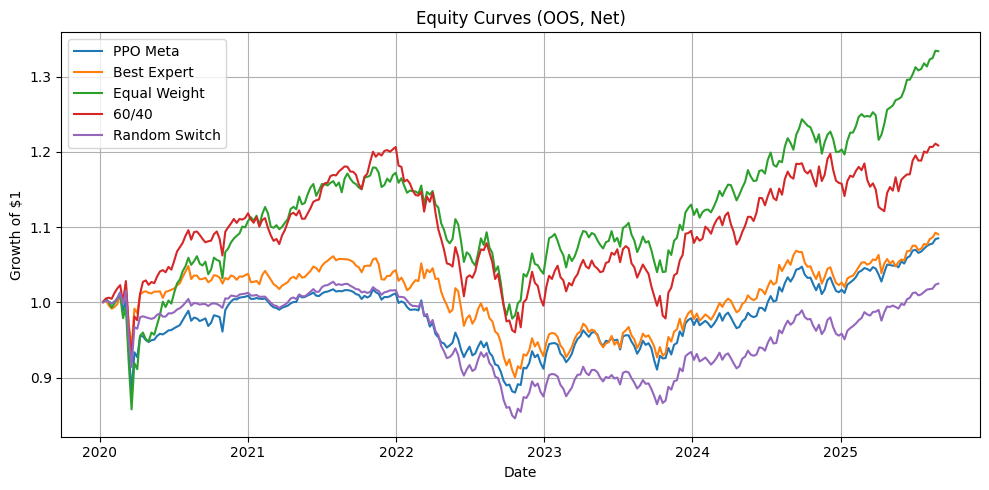

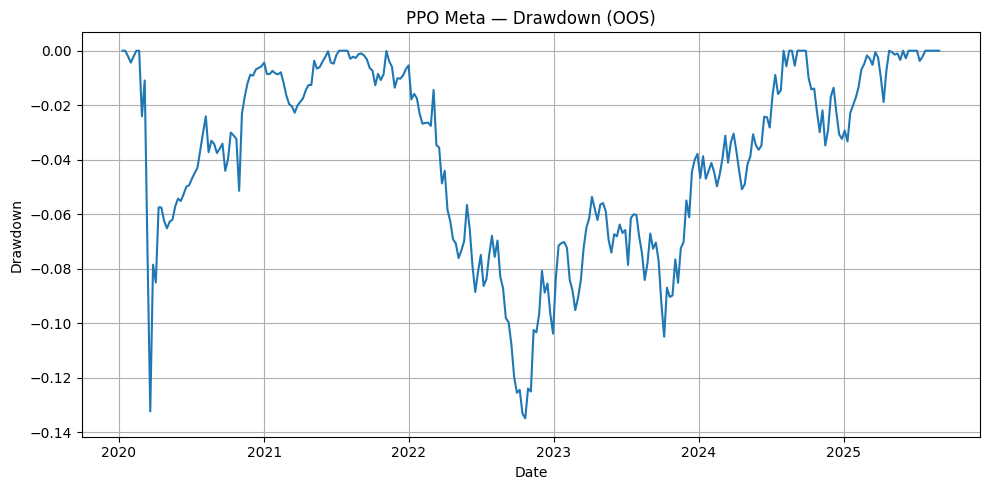

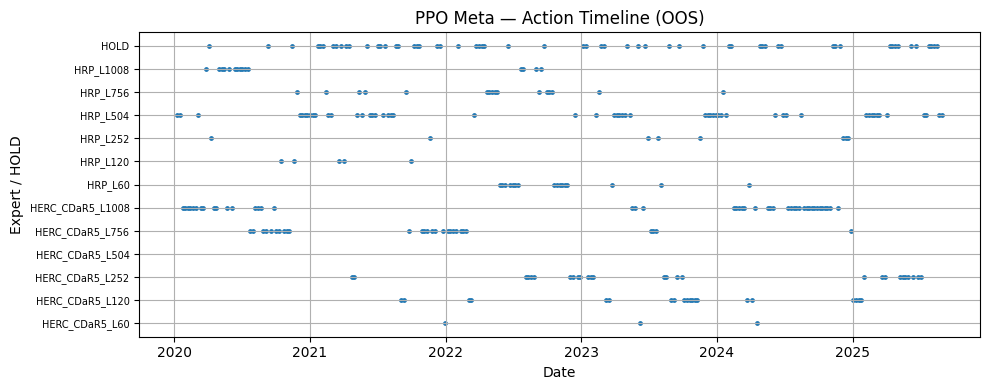

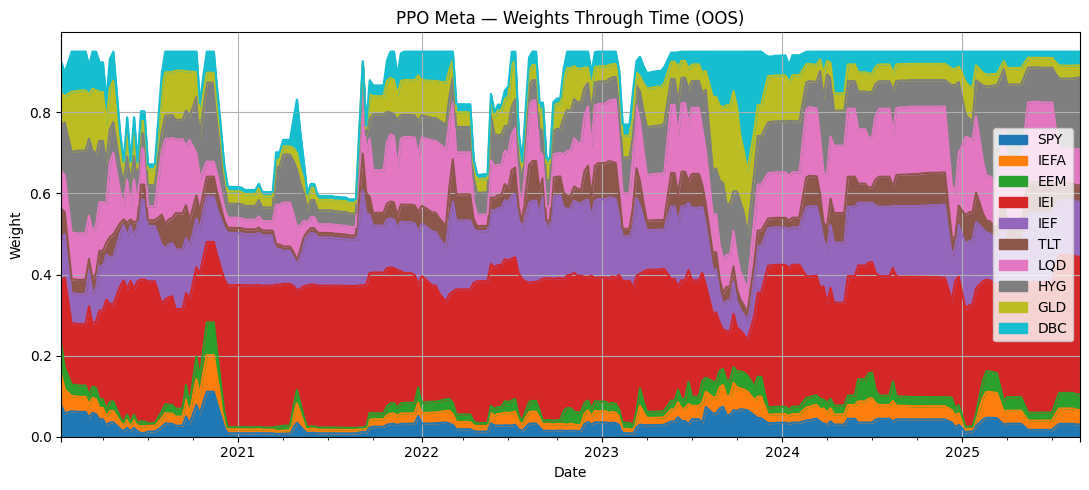

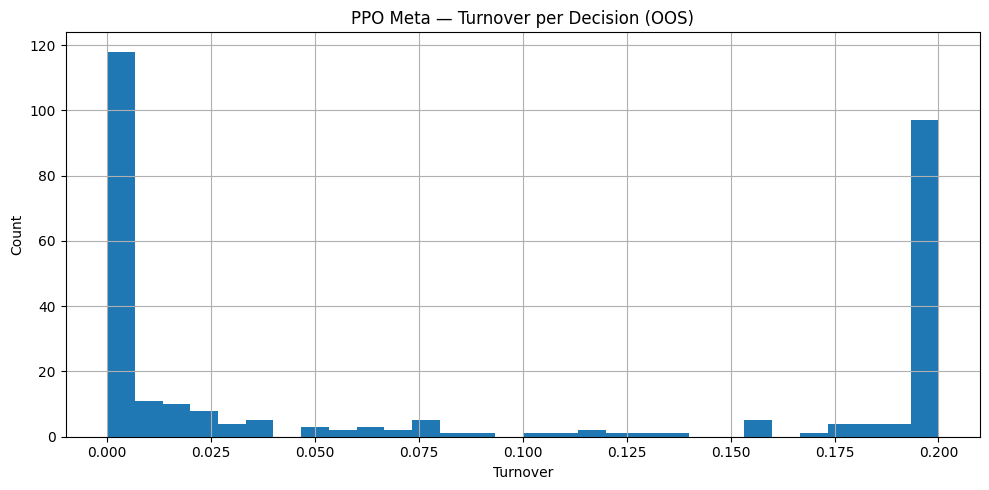

=== OOS Summary (net) ===


,ann_return,sharpe,cvar_5,max_drawdown,avg_turnover,n_steps
strategy,,,,,,
PPO_Meta,1.45%,0.24,-2.28%,nan%,8.62%,295
BestExpert(HERC_CDaR5_L60),1.54%,0.25,-2.18%,-15.14%,12.13%,295
EqualWeight,5.21%,0.59,-2.99%,-17.02%,0.00%,295
60/40,3.39%,0.42,-2.62%,-20.40%,0.43%,295
RandomSwitch,0.44%,0.10,-2.05%,-17.65%,16.67%,295



Figures saved to: /content/outputs/figures
Weights (PPO) saved to: /content/outputs/series_oos/ppo_meta_weights_oos.csv
✅ Visualization complete.


In [12]:
# --- Visualization: PPO vs baselines, action timeline, weights through time (pandas>=2 fix) ---

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from stable_baselines3 import PPO

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["axes.grid"] = True

OUT_SERIES_DIR = OUTPUTS_DIR / "series_oos"
FIG_DIR = OUTPUTS_DIR / "figures"
FIG_DIR.mkdir(parents=True, exist_ok=True)

def read_series(path, name=None):
    """Robustly read a single-column CSV as a Series (pandas>=2 compatible)."""
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    if df.shape[1] == 1:
        s = df.iloc[:, 0]
    else:
        # fallback: pick first column
        s = df[df.columns[0]]
    if name is not None:
        s.name = name
    return s

# ---------- Load OOS series ----------
ppo_net     = read_series(OUT_SERIES_DIR / "ppo_meta_net_returns.csv", name="net_ret")
ppo_turn    = read_series(OUT_SERIES_DIR / "ppo_meta_turnover.csv",    name="turnover")
ppo_actions = read_series(OUT_SERIES_DIR / "ppo_meta_actions.csv",     name="action").astype(int)

best_expert_net = read_series(OUT_SERIES_DIR / "best_expert_net_returns.csv")
eqw_net         = read_series(OUT_SERIES_DIR / "equal_weight_net_returns.csv")
b6040_net       = read_series(OUT_SERIES_DIR / "60_40_net_returns.csv")
rand_net        = read_series(OUT_SERIES_DIR / "random_switcher_net_returns.csv")

summary_df = pd.read_csv(OUTPUTS_DIR / "oos_summary.csv", index_col=0)

# ---------- Equity curves ----------
def equity_curve(net_ret: pd.Series) -> pd.Series:
    s = (1.0 + net_ret.fillna(0.0)).cumprod()
    s.name = "equity"
    return s

eq_ppo  = equity_curve(ppo_net)
eq_best = equity_curve(best_expert_net.reindex_like(ppo_net))
eq_eqw  = equity_curve(eqw_net.reindex_like(ppo_net))
eq_6040 = equity_curve(b6040_net.reindex_like(ppo_net))
eq_rand = equity_curve(rand_net.reindex_like(ppo_net))

plt.figure()
plt.plot(eq_ppo.index, eq_ppo.values, label="PPO Meta")
plt.plot(eq_best.index, eq_best.values, label="Best Expert")
plt.plot(eq_eqw.index,  eq_eqw.values,  label="Equal Weight")
plt.plot(eq_6040.index, eq_6040.values, label="60/40")
plt.plot(eq_rand.index, eq_rand.values, label="Random Switch")
plt.title("Equity Curves (OOS, Net)")
plt.xlabel("Date"); plt.ylabel("Growth of $1")
plt.legend(loc="best")
plt.tight_layout()
plt.savefig(FIG_DIR / "equity_oos.png", dpi=150)
plt.show()

# ---------- Drawdown (PPO only) ----------
ec = eq_ppo
dd = ec / ec.cummax() - 1.0

plt.figure()
plt.plot(dd.index, dd.values)
plt.title("PPO Meta — Drawdown (OOS)")
plt.xlabel("Date"); plt.ylabel("Drawdown")
plt.tight_layout()
plt.savefig(FIG_DIR / "ppo_drawdown_oos.png", dpi=150)
plt.show()

# ---------- Action timeline (PPO) ----------
labels = list(experts_reg["id"]) + ["HOLD"]
action_idx = ppo_actions.reindex(eq_ppo.index).astype(int)
action_lbl = action_idx.map(lambda i: labels[i] if 0 <= i < len(labels) else "HOLD")

label_to_int = {lab: i for i, lab in enumerate(labels)}
y_vals = action_lbl.map(label_to_int)

plt.figure(figsize=(10, 4))
plt.scatter(action_lbl.index, y_vals.values, s=6)
plt.yticks(range(len(labels)), labels, fontsize=7)
plt.title("PPO Meta — Action Timeline (OOS)")
plt.xlabel("Date"); plt.ylabel("Expert / HOLD")
plt.tight_layout()
plt.savefig(FIG_DIR / "ppo_actions_timeline_oos.png", dpi=200)
plt.show()

# ---------- Re-roll OOS to capture weights-through-time for PPO ----------
oos_env = make_env_for_period(CFG_SPLITS["oos_start"], CFG_SPLITS["oos_end"])
ppo_model = PPO.load(MODELS_DIR / "ppo_best.zip", device="auto")

s, info = oos_env.reset(seed=CFG_PPO["seed"])
dates_next, weights_rows = [], []

while True:
    a, _ = ppo_model.predict(s, deterministic=True)
    s, reward, terminated, truncated, info = oos_env.step(int(a))
    dates_next.append(pd.Timestamp(info["next_date"]))
    weights_rows.append(pd.Series(info["weights"], index=ASSETS))
    if terminated or truncated:
        break

weights_df = pd.DataFrame(weights_rows, index=pd.DatetimeIndex(dates_next))
weights_df.to_csv(OUT_SERIES_DIR / "ppo_meta_weights_oos.csv")

plt.figure(figsize=(11, 5))
weights_df.plot.area(ax=plt.gca())
plt.title("PPO Meta — Weights Through Time (OOS)")
plt.xlabel("Date"); plt.ylabel("Weight")
plt.tight_layout()
plt.savefig(FIG_DIR / "ppo_weights_oos.png", dpi=150)
plt.show()

# ---------- Turnover distribution ----------
plt.figure()
plt.hist(ppo_turn.dropna().values, bins=30)
plt.title("PPO Meta — Turnover per Decision (OOS)")
plt.xlabel("Turnover"); plt.ylabel("Count")
plt.tight_layout()
plt.savefig(FIG_DIR / "ppo_turnover_hist_oos.png", dpi=150)
plt.show()

# ---------- Show summary table ----------
print("=== OOS Summary (net) ===")
display(summary_df.style.format({
    "ann_return": "{:.2%}",
    "sharpe": "{:.2f}",
    "cvar_5": "{:.2%}",
    "max_drawdown": "{:.2%}",
    "avg_turnover": "{:.2%}",
    "n_steps": "{:d}"
}))

print("\nFigures saved to:", FIG_DIR)
print("Weights (PPO) saved to:", OUT_SERIES_DIR / "ppo_meta_weights_oos.csv")
print("✅ Visualization complete.")


In [15]:
# --- Report patch & extensions ---
# Fix the HOLD-under-stress calculation (index alignment), add PPO max drawdown to summary context,
# and print a few extra diagnostics you can paste back for analysis.

import pandas as pd, numpy as np, json
from pathlib import Path

pd.set_option("display.width", 140)
pd.set_option("display.max_columns", 50)

OUT_SERIES_DIR = OUTPUTS_DIR / "series_oos"

def read_series(path, name=None):
    df = pd.read_csv(path, index_col=0, parse_dates=True)
    s = df.iloc[:, 0]
    if name: s.name = name
    return s

# Load core artifacts
summary_df = pd.read_csv(OUTPUTS_DIR / "oos_summary.csv", index_col=0)

ppo_net     = read_series(OUT_SERIES_DIR / "ppo_meta_net_returns.csv", "PPO_net")
ppo_turn    = read_series(OUT_SERIES_DIR / "ppo_meta_turnover.csv", "PPO_turnover")
ppo_actions = read_series(OUT_SERIES_DIR / "ppo_meta_actions.csv", "PPO_action").astype(int)

# 1) Add PPO max drawdown to the context (was NaN in the summary table)
def max_drawdown_ratio_from_returns(weekly_ret: pd.Series):
    ec = (1.0 + weekly_ret.fillna(0)).cumprod()
    dd = ec / ec.cummax() - 1.0
    return float(dd.min()), dd.idxmin()

ppo_maxdd, ppo_maxdd_when = max_drawdown_ratio_from_returns(ppo_net)

print("### PATCHED METRICS ###")
print(f"PPO max drawdown (ratio): {ppo_maxdd:.2%} at {ppo_maxdd_when.date() if pd.notna(ppo_maxdd_when) else 'N/A'}")

# 2) Recompute HOLD-under-stress properly (align decision dates -> next dates)
ids_oos = indices_for_period(CFG_SPLITS["oos_start"], CFG_SPLITS["oos_end"])
decisions_oos = decision_dates.iloc[ids_oos]
nxts_oos = next_dates.iloc[ids_oos]

spy_w_dec = returns_w["SPY"].reindex(decisions_oos)
ief_w_dec = returns_w["IEF"].reindex(decisions_oos)

stress_cfg = CFG_PPO["state"]["stress_thresholds"]
stress_decisions = ((spy_w_dec < stress_cfg["spy_weekly_ret"]) &
                    (ief_w_dec > stress_cfg["ief_weekly_ret"])).astype(int)

# Shift stress flags to "next" timestamps so they align with ppo_actions index
stress_next = pd.Series(stress_decisions.values, index=nxts_oos, name="STRESS")

# Align actions (already indexed by next_dates)
act_oos = ppo_actions.reindex(nxts_oos).astype(int)
hold_idx = ACTION_HOLD

overall_hold_rate = (act_oos == hold_idx).mean()
hold_rate_stress  = (act_oos[stress_next == 1] == hold_idx).mean() if (stress_next == 1).sum() > 0 else np.nan
hold_rate_calm    = (act_oos[stress_next == 0] == hold_idx).mean()

print("\n### HOLD behavior (aligned to next_dates) ###")
print(f"Overall HOLD rate              : {overall_hold_rate:.2%}")
print(f"HOLD rate when STRESS=1        : {hold_rate_stress:.2%}")
print(f"HOLD rate when STRESS=0        : {hold_rate_calm:.2%}")
print(f"#stress weeks                  : {(stress_next==1).sum()} / {len(stress_next)}")

# Confusion table STRESS x HOLD
hold_flag = (act_oos == hold_idx).astype(int)
ct = pd.crosstab(stress_next, hold_flag, rownames=["STRESS"], colnames=["HOLD"])
print("\nSTRESS x HOLD confusion table (counts):")
print(ct.to_string())

# 3) Stress vs non-stress performance (weekly net returns)
ppo_net_oos = ppo_net.reindex(nxts_oos)
mu_stress = ppo_net_oos[stress_next == 1].mean()
mu_calm   = ppo_net_oos[stress_next == 0].mean()
print("\n### PPO weekly net returns under regimes ###")
print(f"Mean net return when STRESS=1  : {mu_stress:.2%}")
print(f"Mean net return when STRESS=0  : {mu_calm:.2%}")

# 4) Cost impact approximation from turnover (2 bps/side applied to turnover)
cost_bps = CFG_PPO["reward"]["trade_cost_bps"]
avg_turn = ppo_turn.mean()
avg_cost_per_step = (cost_bps * 1e-4) * avg_turn
ann_cost_drag = ((1.0 - avg_cost_per_step) ** 52) - 1.0  # compounding approximation
print("\n### Cost impact (approx) ###")
print(f"Average turnover per step      : {avg_turn:.2%}")
print(f"Avg cost per step (net of turnover): {avg_cost_per_step:.4%}")
print(f"Implied annual drag (approx)   : {ann_cost_drag:.2%}")

# 5) Top-5 expert usage (frequency)
labels = list(experts_reg["id"]) + ["HOLD"]
use_counts = ppo_actions.value_counts().sort_values(ascending=False)
top5 = use_counts.head(5).rename("count").to_frame()
top5["label"] = top5.index.map(lambda i: labels[i] if 0 <= i < len(labels) else "HOLD")
top5["pct"] = top5["count"] / use_counts.sum()
print("\n### Top-5 action usage ###")
print(top5[["label","count","pct"]].to_string(index=False, formatters={"pct": "{:.2%}".format}))

print("\n### NOTE ###")
print("- The OOS summary CSV left PPO max_drawdown as NaN because that metric wasn't stored in the training eval;")
print("  the patched value above is the correct ratio-based max drawdown from the OOS net series.")
print("- HOLD-under-stress is now computed with aligned indices (decision→next), fixing the KeyError you saw.")
print("\n✅ Patch/extended report complete — copy all of this output back for analysis.")


### PATCHED METRICS ###
PPO max drawdown (ratio): -13.48% at 2022-10-21

### HOLD behavior (aligned to next_dates) ###
Overall HOLD rate              : 20.00%
HOLD rate when STRESS=1        : 14.81%
HOLD rate when STRESS=0        : 20.52%
#stress weeks                  : 27 / 295

STRESS x HOLD confusion table (counts):
HOLD      0   1
STRESS         
0       213  55
1        23   4

### PPO weekly net returns under regimes ###
Mean net return when STRESS=1  : 0.42%
Mean net return when STRESS=0  : -0.01%

### Cost impact (approx) ###
Average turnover per step      : 8.62%
Avg cost per step (net of turnover): 0.0017%
Implied annual drag (approx)   : -0.09%

### Top-5 action usage ###
           label  count    pct
            HOLD     59 20.00%
        HRP_L504     53 17.97%
HERC_CDaR5_L1008     45 15.25%
 HERC_CDaR5_L756     28  9.49%
 HERC_CDaR5_L252     27  9.15%

### NOTE ###
- The OOS summary CSV left PPO max_drawdown as NaN because that metric wasn't stored in the training eval;


In [19]:
# Zip the requested folders into a single archive: data, experts_cache, models, outputs, sample_data
# The zip will be created in /content and (if on Colab) offered for download.

from pathlib import Path
import zipfile, os, time

BASE = Path("/content")
FOLDERS = ["data", "experts_cache", "models", "outputs", "sample_data"]
existing = [BASE/f for f in FOLDERS if (BASE/f).exists()]

if not existing:
    raise FileNotFoundError("None of the target folders exist in /content: " + ", ".join(FOLDERS))

zip_name = f"project_bundle_{time.strftime('%Y%m%d_%H%M%S')}.zip"
zip_path = BASE / zip_name

file_count = 0
with zipfile.ZipFile(zip_path, "w", compression=zipfile.ZIP_DEFLATED) as zf:
    for folder in existing:
        for p in folder.rglob("*"):
            if p.is_file():
                # Store paths relative to /content so the folder structure is preserved
                zf.write(p, arcname=p.relative_to(BASE))
                file_count += 1

size_mb = zip_path.stat().st_size / (1024*1024)

print("✅ Zip created:")
print(" Path :", zip_path)
print(f" Size : {size_mb:.2f} MB")
print(" Folders included:", [str(p.relative_to(BASE)) for p in existing])
print(" Total files zipped:", file_count)

# Try to trigger download in Google Colab (safe to ignore elsewhere)
try:
    from google.colab import files
    print("\nOffering download…")
    files.download(str(zip_path))
except Exception as e:
    print("\n(Download not triggered automatically; you can manually download the file from the left Files panel.)")


✅ Zip created:
 Path : /content/project_bundle_20250908_144326.zip
 Size : 20.82 MB
 Folders included: ['data', 'experts_cache', 'models', 'outputs', 'sample_data']
 Total files zipped: 65

Offering download…


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>